In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import gamma
from scipy.optimize import curve_fit
from itertools import combinations

## Reads in the .csv files for plotting together
Asks for how many .csv files you would like to plot first, then you input the path name to each .csv file you would like to plot. Note that the first .csv file will be first in the legend etc.

In [8]:
def load_csv_files(num_files):
    data_dict = {}
    
    for i in range(num_files):
        file_path = input(f"Enter the path of CSV file {i + 1}: ")
        filename = file_path.split("/")[-1]  # Extract the filename from the path
        if filename.endswith('.csv'):
            with open(file_path, 'r') as csv_file:
                csv_reader = csv.reader(csv_file)
                next(csv_reader)  # Skip the first row
                data = [[float(value) for value in row] for row in csv_reader]  # Cast values to float
                data_dict[filename] = data
        else:
            print(f"{filename} is not a CSV file. Skipping...")

    return data_dict

if __name__ == "__main__":
    num_files = int(input("Enter the number of CSV files to load: "))
    CDF_data = load_csv_files(num_files)
    
# Flatten the nested lists
CDF_data = {key: [item for sublist in values for item in sublist] for key, values in CDF_data.items()}

Enter the number of CSV files to load: 1
Enter the path of CSV file 1: /Users/steinar/Documents/Data/4 - cell vs. endosomal membrane in fusion/figures and data for publishing/fig. 3 - coverage, trace types and PMV vs. liposome lipid and content mixing/liposome content mixing kinetics, efficiency and coverage (trace type 2 and 3 only)/waiting times/IAV + 20 mol % BMP liposome 1-4 merged.csv


## Remove ending from filenames

In [9]:
corrected_CDF_data = {}
for key, value in CDF_data.items():
    new_key = key[:-15]  # Remove the last XX characters from the key
    corrected_CDF_data[new_key] = value
    
CDF_data = corrected_CDF_data

## Plot the CDF figure and save to desktop

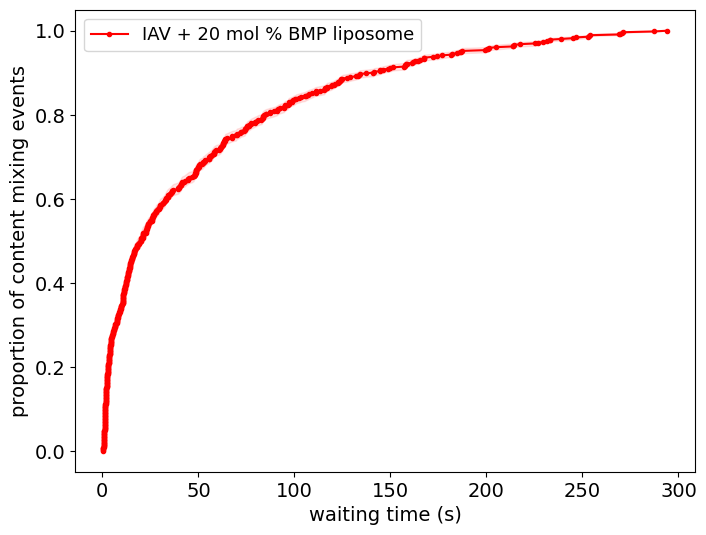

In [10]:
def cdf_gamma_fit(x, a, loc, scale):
    return gamma.cdf(x, a, loc=loc, scale=scale)

# Function to calculate bootstrap samples
def bootstrap_cdf(data, n_bootstrap=1000):
    n = len(data)
    x = np.sort(data)
    y_samples = np.zeros((n_bootstrap, n))
    for i in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        x_sample = np.sort(sample)
        y_sample = np.arange(1, n + 1) / n
        y_samples[i] = np.interp(x, x_sample, y_sample)
    return x, y_samples

# Create a single plot with all dataframes
plt.figure(figsize=(8, 6))

# Define a color scheme for each dataset
colors = ['red','dimgrey', 'lightskyblue', 'dodgerblue', 'blue', 'black', 'grey', 'green']

# Change to the desired font size
plt.rcParams.update({'font.size': 14})

# Loop through the dataframes in the 'CDF_data' dictionary
for i, (df_name, df_item) in enumerate(CDF_data.items()):
    n = len(df_item)
    x = np.sort(df_item)
    y = np.arange(1, n + 1) / n

    try:
        # Plot the CDF with a unique color for each dataset
        plt.plot(x, y, marker='.', linestyle='-', color=colors[i], label=f'{df_name}')
        
        # Fit a gamma distribution to the data
        params, _ = curve_fit(cdf_gamma_fit, x, y, p0=[1, 30, 15])

        # Plot the best-fitting curve (gamma distribution)
        x_fit = np.linspace(min(x), max(x), 100)
        y_fit = cdf_gamma_fit(x_fit, *params)
        #plt.plot(x_fit, y_fit, '', color=colors[i])

        # Bootstrap for IQR
        x_boot, y_boot_samples = bootstrap_cdf(df_item)
        y_lower = np.percentile(y_boot_samples, 25, axis=0)
        y_upper = np.percentile(y_boot_samples, 75, axis=0)

        # Plot the interquartile range
        plt.fill_between(x_boot, y_lower, y_upper, color=colors[i], alpha=0.1)
    except RuntimeError:
        print(f"Fit for {df_name} did not converge.")

# Customize the plot
plt.xlabel('waiting time (s)')
plt.ylabel('proportion of content mixing events')
plt.legend(fontsize = 13)

# Save the figure as a PDF file
folder = '/Users/steinar/Desktop'
filename = '/fusion kinetics plot.pdf'
plt.savefig(folder + filename, format='pdf', bbox_inches='tight')

plt.show()

## calculate median fusion times

In [11]:
median_fusion_time = {}  # Initialize a new dictionary to store the medians

# Loop through the dataframes in the "df" dictionary
for key, df_item in CDF_data.items():
    # Calculate the median for each dataframe and store it in the new dictionary
    median_fusion_time[key] = np.median(df_item)

# Print or use the "median_fusion" dictionary
print("Median Fusion times:")
for key, median_value in median_fusion_time.items():
    print(f"{key}: {median_value}" + " seconds")

Median Fusion times:
IAV + 20 mol % BMP liposome: 20.0 seconds


## check whether the waiting time distributions are significantly different
Uses a permutation test with resampling to determine whether the waiting time lists are from different distributions

In [12]:
def permutation_test(data1, data2, num_permutations=10000):
    """
    Perform a permutation test to compare two datasets.
    
    Parameters:
    data1, data2 : array-like
        The two datasets to compare.
    num_permutations : int
        The number of permutations to perform.
        
    Returns:
    p_value : float
        The p-value of the test.
    """
    data1 = np.array(data1)
    data2 = np.array(data2)
    
    combined = np.concatenate([data1, data2])
    observed_diff = np.abs(np.mean(data1) - np.mean(data2))
    
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_data1 = combined[:len(data1)]
        new_data2 = combined[len(data1):]
        new_diff = np.abs(np.mean(new_data1) - np.mean(new_data2))
        if new_diff >= observed_diff:
            count += 1
            
    p_value = count / num_permutations
    return p_value

def compare_all_datasets(CDF_data, num_permutations=10000):
    """
    Perform a permutation test for all combinations of datasets in CDF_data.
    
    Parameters:
    CDF_data : dict
        Dictionary where each key is a dataset name and its value is a list of waiting times.
    num_permutations : int
        The number of permutations to perform.
        
    Returns:
    results : dict
        Dictionary containing the p-values for all dataset comparisons.
    """
    results = {}
    dataset_names = list(CDF_data.keys())
    for (key1, key2) in combinations(dataset_names, 2):
        data1 = CDF_data[key1]
        data2 = CDF_data[key2]
        p_value = permutation_test(data1, data2, num_permutations)
        results[(key1, key2)] = p_value
        print(f'Permutation test for {key1} and {key2}: p-value = {p_value:.4f}')
    return results

# Run the permutation test for all dataset combinations
results = compare_all_datasets(CDF_data)

## check whether the waiting time distributions are significantly different
Uses a KS test with resampling to determine whether the waiting time lists are from different distributions

In [13]:
import itertools
from scipy.stats import ks_2samp

def pairwise_ks_test(CDF_data):
    # Get all pairs of distributions (combinations of keys)
    pairs = list(itertools.combinations(CDF_data.keys(), 2))
    
    results = {}
    
    for key1, key2 in pairs:
        # Perform the KS test for the two distributions
        stat, p_value = ks_2samp(CDF_data[key1], CDF_data[key2])
        
        # Store the result in a dictionary for reference
        results[(key1, key2)] = {
            'ks_statistic': stat,
            'p_value': p_value
        }
    
    return results

# Run the pairwise KS test
results = pairwise_ks_test(CDF_data)

# Print the results
for pair, result in results.items():
    print(f"KS test:  {pair[0]}  AND  {pair[1]}:  p-value={result['p_value'].round(4)}")